## Scikit Image : Traitement d'images

### Généralités


`Scikit-image` est un module qui vous permet d'effectuer de nombreuses tâches de traitement d'image sous Python, comme : 

* le filtrage d'image, avec ses flous gaussiens et ses détections de contour (par exemple avec le filtre de Sobel)
* les opérations de seuillage à la main ou non, par exemple avec la méthode d'Otsu
* les opérations logiques sur les images binaires (ou non) permettant d'éroder des images ou de les dilater, et à partir de ces opérations d'ouvrir ou de fermer les 'trous' de certains motifs
* l'étiquetage (_labelling_) de données permettant de compter par exemple des objets et d'extraire leurs caractéristiques à partir d'une image binaire. 

Ce tutoriel va considérer des cas concrets de traitement d'image (pas trop compliqués).

Sachez qu'il existe en plus des leçons et tutoriels proposés par les développeurs de `scikit-image`, [disponibles sur internet](https://scikit-image.org/skimage-tutorials/) notamment [en version interactive](https://github.com/scikit-image/skimage-tutorials). Pour accéder à la version interactive -- qui n'est plus complètement à jour, mais toujours utile --  cliquez sur le lien `Binder`, comme pour ce tutoriel, et allez ouvrir les fichiers dans le dossier `lectures`. Les éléments-clés du module sont assez bien expliqués. 

![img](./resources/scikit_image_tutorials_load_cropped.gif)

Je vais me contenter dans ce tutoriel de vous expliquer comment on peut détecter des objets dans une image. J'en profiterai pour introduire certaines fonctions d'intérêt de `Scikit-Image`. Trois configurations seront étudiées : 

1. [La détection de bulles, etc. ou tout objet qui a un contour sombre et un centre clair](#detection-de-bulles--seuillage-segmentation-dilatation-morphologique)
2. [La détection de particules ou tout objet uniformément clair ou sombre par rapport au fond par _watershed_](#détection-de-particules-1--filtre-gaussien-contraste-adaptatif-watershed)
3. [La détection de particules par transformée de Hough circulaire](#detection-de-particules-2--filtre-de-canny-et-transformee-de-hough)


### Detection de bulles : seuillage, segmentation, dilatation morphologique


L'objectif ici va être de détecter le contour de particules -- des bulles -- d'un écoulement microfluidique, plus particulièrement celui-ci (Crédits : [Biswal Lab, Université de Rice](https://news2.rice.edu/2018/12/06/tiny-bubbles-break-each-other-up/)) : 

![img](./resources/bubbles.jpg)

L'image est bien contrastée et plutôt homogène en luminosité. Elle souffre cependant d'une quantification du nombre de couleurs (on peut le voir à gauche, il y a des "grains" sombres ou clairs dans une forêt de pixels plus clairs ou sombres à la place d'un gradient propre de luminosité). 

#### Première étape : seuillage 

Segmenter une image s'effectue généralement sur une image binaire, c'est à dire qui contient seulement des zéros (0) et des (1). On peut seuiller une image standard pour la transformer en image binaire. Se pose alors souvent la question du _choix_ de ce seuil. On peut le prendre à la main, à l'aide notamment d'un histogramme : 

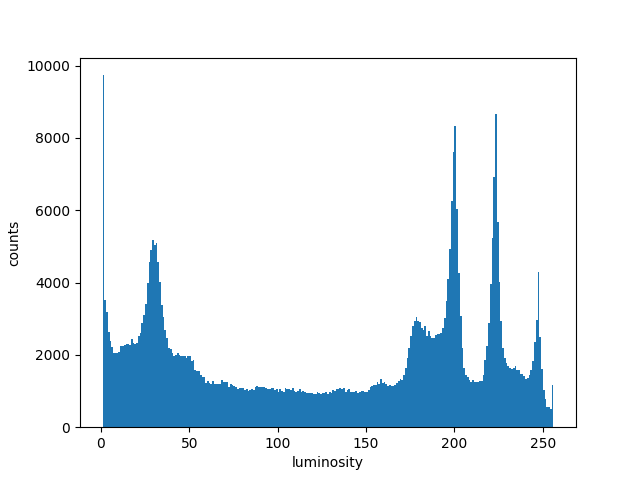

In [320]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

my_image = np.array(Image.open('resources/bubbles.jpg').convert('L'))   # Convert to grayscale

fig, ax = plt.subplots()
hist, bins = np.histogram(my_image.ravel(), bins=255)

ax.bar(x=bins[1:], height=hist, width=np.diff(bins[:2]), bottom=0, align='edge')
ax.set_xlabel('luminosity')
ax.set_ylabel('counts')

plt.show()

On se dit alors qu'on pourrait choisir un seuil aux alentours de 100-120 et le tour est joué ! Sachez qu'il existe des méthodes automatiques de `Scikit-Image` qui permettront de retrouver automatiquement une valeur `optimale` du seuil, par exemple la méthode d'[Otsu](https://fr.wikipedia.org/wiki/M%C3%A9thode_d%27Otsu) ou celle du [minimum bimodal](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_minimum).

In [321]:
from skimage.filters import threshold_otsu, threshold_minimum

otsu = threshold_otsu(my_image)
mini = threshold_minimum(my_image)

print(f'Otsu threshold : {otsu}, Bimodal threshold : {mini}.')

Otsu threshold : 120, Bimodal threshold : 121.


Les valeurs sont bien dans les clous ! On peut alors définir et afficher l'image binaire seuillée très simplement : 

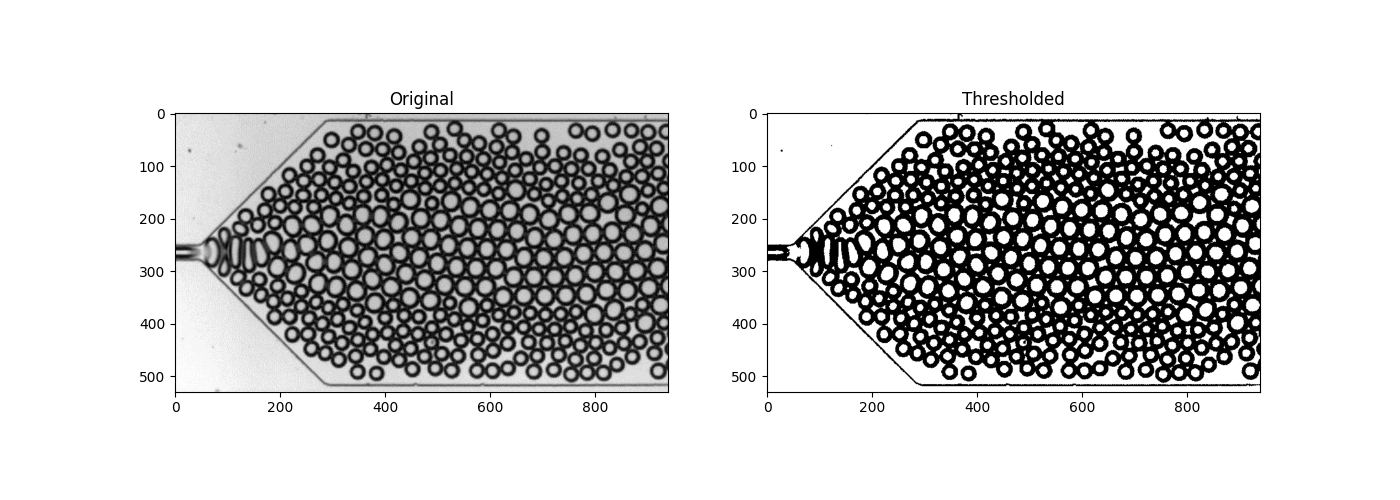

In [326]:
bin_img = my_image > otsu + 20

fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(w=14,h=5)
ax[0].imshow(my_image, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(bin_img, cmap='gray')
ax[1].set_title('Thresholded')
plt.show()

Si votre contraste n'est pas bon ou votre lumière est inhomogène, je vous laisse jeter un oeil à la documentation de `scikit-image` (allez regarder notamment la leçon sur les filtres [_top-hat_](https://github.com/scikit-image/skimage-tutorials/blob/main/lectures/5_tophat_filters.ipynb), plutôt bien faite).

#### Segmentation de l'image

Vous l'aurez sûrement constaté, nos objets forment en fait des anneaux "sombres" entre un bord extérieur clair (quoique, pas toujours _si_ clair) et un bord intérieur clair (là, c'est toujours le cas). Essayons de demander naïvement à la fonction `skimage.measure.label()` de compter les objets -- __clairs__ par défaut -- de mon image et de présenter les résultats dans un dictionnaire avec la fonction `skimage.measure.regionprops_table()`. On lui demande de synthétiser certaines propriétés pour nous ([la liste des propriétés valides est disponible ici](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops)):

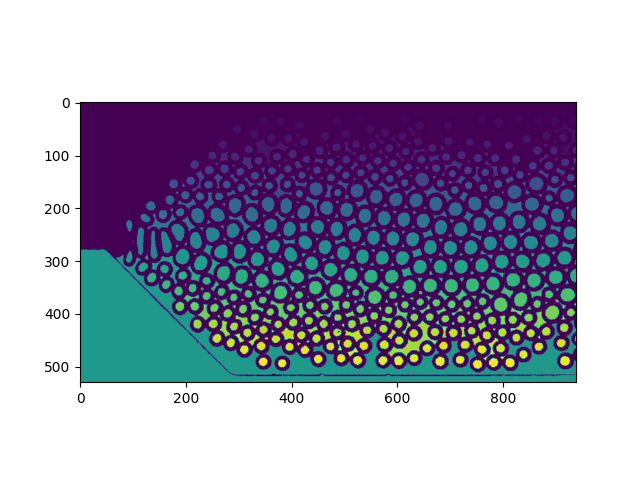

In [327]:
import skimage.measure as ms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib widget

my_image = np.array(Image.open('resources/bubbles.jpg').convert('L'))   # Convert to grayscale
bin_img = my_image > otsu
label_img = ms.label(bin_img)
props  = ms.regionprops_table(label_img, properties=['label', 'centroid', 'area', 'eccentricity'])
props.keys()

fig, ax = plt.subplots()
ax.imshow(label_img)

##### Sélection par la taille 
En fait ici l'algorithme ne fait pas la distinction entre les _vraies bulles_ dont le centre est clair et les _interstices_ entre bulles qui sont également clairs, mais moins circulaires. C'est somme toute logique ! On peut tout d'abord déjà filtrer par taille les objets que nous avons trouvés. S'ils sont trop grands, on va les sortir, et s'ils sont trop petits également. Aidons-nous de [Pandas](./Application_D_Pandas.ipynb) et filtrons les valeurs les plus aberrantes :

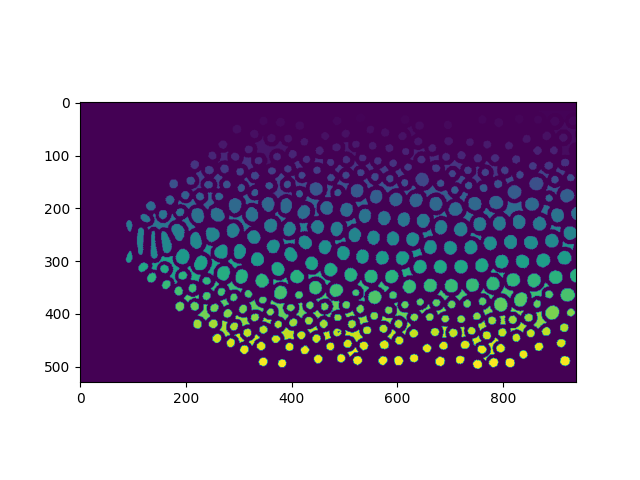

In [328]:
# Selection based on size

import pandas as pd
data = pd.DataFrame(data=props)

bad_area = (data['area'] < 100) | (data['area'] > 1000)  # Define selection for spurious areas
bad_labels = data.loc[bad_area,'label']                   # Find labels corresponding to spurious areas
for bad_label in bad_labels:
    label_img[label_img == bad_label] = 0             # Remove regions corresponding to bad labels from image

fig, ax = plt.subplots()
ax.imshow(label_img)

##### Sélection par la convexité 

Une possibilité supplémentaire pour nous débarrasser des derniers objets un peu embêtants va consister à les trier par convexité, ou plus précisément selon leur _solidité_, c'est à dire le nombre de pixels de l'objet sur le nombre de pixels de [l'enveloppe convexe de l'objet](https://scikit-image.org/docs/dev/auto_examples/edges/plot_convex_hull.html). La quantité est donc comprise entre 1 (objet convexe) et 0 (un truc vraiment concave de chez concave).

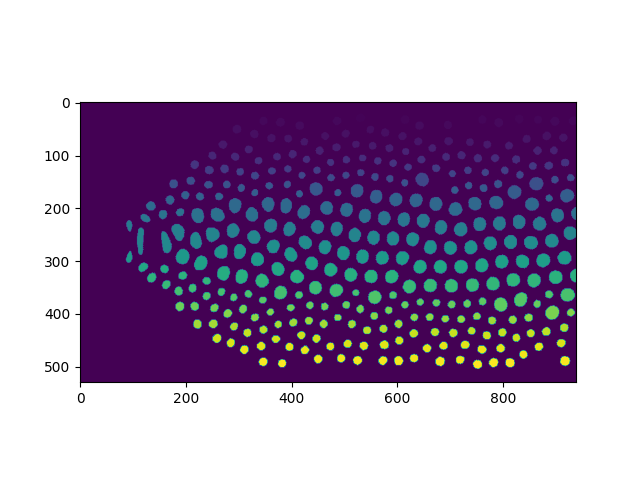

In [329]:
clean_data = pd.DataFrame(data=ms.regionprops_table(label_img, properties=['label', 'centroid', 'area', 'eccentricity', 'solidity']))

bad_solidity = clean_data['solidity'] < 0.90
bad_labels = clean_data.loc[bad_solidity,'label']          # Find labels corresponding to spurious areas
for bad_label in bad_labels:
    label_img[label_img == bad_label] = 0       # Remove regions corresponding to bad labels from image

fig, ax = plt.subplots()
ax.imshow(label_img)

plt.show()

Et voilà ! On est plutôt bien propre :-), on a détecté l'intérieur de quasiment toutes nos bulles.

##### Sélection par l'excentricité

De la même manière, on peut s'affranchir de pas mal d'objets qui ne sont pas des bulles si on supprime tous les objets qui ne sont pas suffisamment ronds. Pour cela, on va filtrer nos objets en fonction de leur excentricité. On applique cette "moulinette" sur les objets déjà filtrés en taille : 

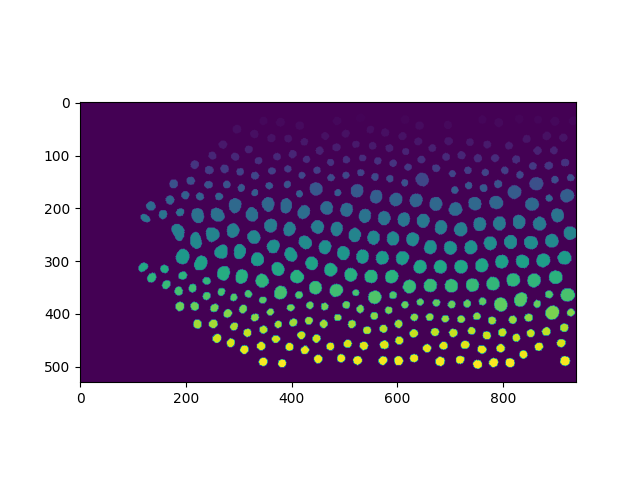

In [330]:
clean_data = pd.DataFrame(data=ms.regionprops_table(label_img, properties=['label', 'centroid', 'area', 'eccentricity']))

bad_ecc = (data['eccentricity'] > 0.80)         # Define selection for bad eccentricities
bad_labels = data.loc[bad_ecc,'label']          # Find labels corresponding to spurious areas
for bad_label in bad_labels:
    label_img[label_img == bad_label] = 0       # Remove regions corresponding to bad labels from image

fig, ax = plt.subplots()
ax.imshow(label_img)

plt.show()

#### Retrouver le diamètre _extérieur_ des bulles ? 

On a réussi à isoler la partie _intérieure_ des bulles de notre système. Mais ... euh ... comment peut-on alors remonter à une mesure (on l'espère fiable) du diamètre _externe_ de nos bulles ? Une idée pas si bête va consister à simplement ajouter une quantité _arbitraire_ de pixels autour de la partie intérieure (une _épaisseur_). Pour cela, on va effectuer ce qu'on appelle une [_opération morphologique de dilatation_](https://en.wikipedia.org/wiki/Dilation_(morphology)) (ouh, le gros mot !). 

Le concept n'est pas si compliqué que ça : les pixels à zéro (hors de tout objet) mais avoisinant les pixels pas à zéro (dans un objet) vont être _inclus_ dans l'objet. On peut répéter l'opération plusieurs fois. Je vais devoir définir mon voisinage à partir d'une matrice, où mon pixel d'intérêt est au 'centre' et les coefficients mis à 1 représentent les pixels voisins de mon pixel d'intérêt. __Hein__ ? Prenons un exemple : si je veux juste choisir les pixels _premiers voisins_ (sans les diagonales), je peux définir ma matrice de voisinage comme : 

$$\mathcal{V} =  \left ( \begin{array}{ccc} 0 & 1 & 0 \\ 1 & 1 & 1 \\ 0 & 1 & 0 \end{array} \right ) $$

(__Mini-exercice__ : Essayez de voir à quoi ressemblera une matrice de voisinage où vous considérez également les pixels voisins en diagonale)

Une fois qu'on a défini un voisinage (ou une _taille_ de voisinage), on peut superposer l'image initiale et les bulles détectées et voir si l'accord est bon, par exemple de la manière suivante. Cela va en général bien fonctionner si tous vos objets ont un contour ayant la même épaisseur.

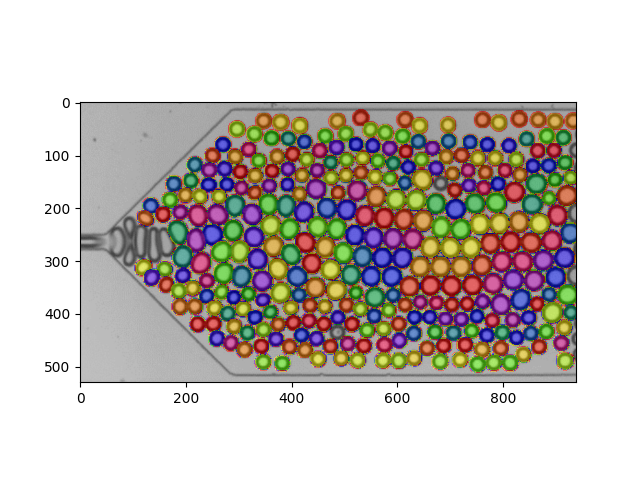

In [331]:
import skimage.morphology as mph
import matplotlib.cm as cm

def dilation_neighborhood(size=9):
    """This function defines a neighborhood for morphological dilation 
    based on a _size_ (default 9)"""
    X, Y = np.meshgrid(np.arange(1,size*2), np.arange(1,size*2))
    return (X-size)**2 + (Y-size)**2 < (size-1)**2

dilated_img = mph.dilation(label_img, dilation_neighborhood(size=9))

# Overlay original image and dilated image with individual colors for each bubble
cmap = cm.get_cmap('prism')
cmap.set_under('gray')
fig, ax = plt.subplots()
ax.imshow(my_image, cmap='gray')
ax.imshow(dilated_img, cmap=cmap, alpha=0.5, vmin=0.5)

plt.show()

Vous pouvez alors enfin re-lancer la moulinette des _propriétés_ avec `skimage.measure.regionprops_table()` sur l'image correctement étiquetée, pour avoir par exemple la distribution de taille de vos bulles. On peut les comparer aux tailles de bulles 'non dilatées' pour vérifier que rien n'est allé de travers lors de la dilatation : 

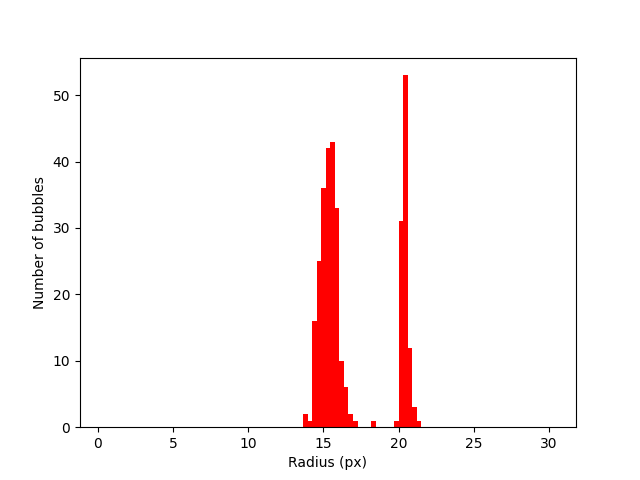

In [332]:
int_objs = pd.DataFrame(ms.regionprops_table(label_img, properties=['label', 'centroid', 'area', 'eccentricity', 'solidity']))
ext_objs = pd.DataFrame(ms.regionprops_table(dilated_img, properties=['label', 'centroid', 'area', 'eccentricity', 'solidity']))
int_radius = np.sqrt(int_objs['area']/np.pi)
ext_radius = np.sqrt(ext_objs['area']/np.pi)

int_hist, int_bins = np.histogram(int_radius, bins=np.linspace(0,30,100))
ext_hist, ext_bins = np.histogram(ext_radius, bins=np.linspace(0,30,100))

fig, ax = plt.subplots()
ax.bar(x=ext_bins[1:], height=ext_hist, width=np.diff(ext_bins[:2]), bottom=0, align='edge', facecolor='red')
# ax.bar(x=int_bins[1:], height=int_hist, width=np.diff(int_bins[:2]), bottom=0, align='edge', facecolor='blue', alpha=0.25)
ax.set_xlabel('Radius (px)')
ax.set_ylabel('Number of bubbles')
plt.show()

### Detection de particules 1 : filtre gaussien, contraste adaptatif, _watershed_ 

Dans cette partie, nous allons nous intéresser à une image où cette fois-ci on a des particules (ici sombres) sur un fond clair, avec pas mal de bruit. On devine quand même de nombreuses particules, et nous allons essayer ici de les détecter du mieux qu'on peut. Ce ne sera peut-être pas parfait, mais vous verrez on s'en sort finalement.

![img](./resources/FredBlanc_Particles.png)

#### Pré-traitements : flou gaussien et contraste adaptatif
 
L'image n'est pas illuminée complètement de la même manière sur la totalité de l'image, et on observe pas mal de bruit lié aux (infimes) différences d'indice optique entre les particules et le fluide (fluorescent). On peut remédier à ce problème en appliquant un filtre passe-bas à l'image avec la fonction `skimage.filters.gaussian()`. Elle prend en entrée l'image initiale et une taille (en px) sur laquelle le flou va s'effectuer. 

_Note_ : la fonction vous renverra une image avec des valeurs comprises entre 0 et 1, à moins que vous indiquiez l'argument supplémentaire `preserve_range=True`.

On va ensuite appliquer un algorithme de contraste adaptatif, qui va _en gros_ effectuer un histogramme local de notre image dans différentes boîtes (on en fixera la taille), qui les comparera entre différentes régions de l'image et normalisera le contraste local de l'image afin que tous les histogrammes aient les mêmes propriétés (moyenne et variance). On appelle cet algorithme le [_CLAHE_](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization). La fonction s'appelle `skimage.exposure.equalize_adapthist()` sous Scikit-Image : 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.filters as filt
import skimage.exposure as expos
from PIL import Image

my_image = np.array(Image.open('resources/FredBlanc_Particles.png').convert('L'))
filt_img = filt.gaussian(my_image, sigma=2)
clh_img = expos.equalize_adapthist(filt_img, kernel_size=63)

fig, ax = plt.subplots()
ax.imshow(clh_img, cmap='gray')
plt.show()

#### Seuillage et séparation de particules avec _watershed_

Nous allons maintenant pouvoir seuiller nos images, mais contrairement au cas des bulles où nos objets étaient _naturellement_ bien séparés, nous sommes dans une situation ici où nos objets _bavent_ les uns sur les autres, même pour un contraste optimal. Reprenons notre image pré-traitée, `clh_img`. Je choisis volontairement un seuil un peu plus bas que ce que recommanderait le seuillage automatique d'[Otsu (vu plus haut)](https://fr.wikipedia.org/wiki/M%C3%A9thode_d%27Otsu).

My threshold : 0.4, automated threshold : 0.49


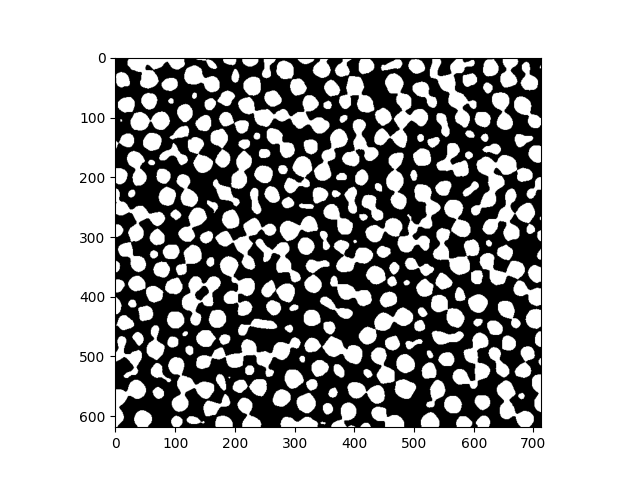

In [254]:
from skimage.filters import threshold_otsu

my_threshold = 0.40
auto_threshold = threshold_otsu(clh_img)
ths_img = clh_img < my_threshold
print(f'My threshold : {my_threshold}, automated threshold : {auto_threshold:.2f}')

fig, ax = plt.subplots()
ax.imshow(ths_img, cmap='gray')
plt.show()

L'image seuillée contient des grappes de particules séparées par des petits canaux. On peut en fait s'en débarrasser si nous appliquons un algorithme de _watershed_ (appelée 'de ligne de partage des eaux' en bon françois). Pour cela, on va calculer une quantité qui est la _distance_ d'un pixel blanc au plus proche pixel noir avoisinant dans l'image seuillée. Les pixels au centre d'une particule auront alors une valeur plus élevée qu'aux bords ; ils auront une valeur proche du _rayon_ des particules.

La fonction qui calcule ces distances existe ... mais sous _Scipy_, plus précisément comme `scipy.ndimage.distance_transform_edt()`, donc ne perdez pas trop de temps à la chercher sous Scikit-Image :-) . On va en profiter également pour y faire figurer les maxima _locaux_ de cette image des distances, qui aura son importance. On peut la calculer à l'aide de la fonction `skimage.feature.peak_local_max()`, et on peut l'obliger à considérer des maxima locaux : 
- sur une zone d'au moins $5\times 5$ pixels avec l'argument `footprint` (une matrice $2\times 2$ ici) 
- distants entre eux d'un certain nombre de pixels avec `min_distance` (un nombre positif)

Cela permettra plus tard de supprimer de _très nombreux_ pics parasites qui perturberaient le fonctionnent de notre algorithme.

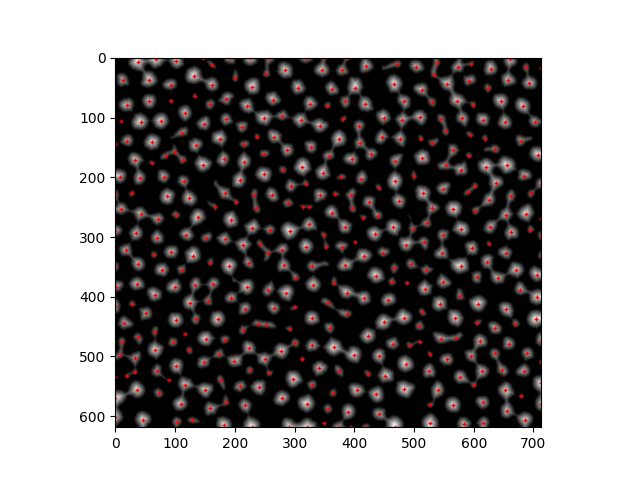

In [255]:
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max

dist_map = distance_transform_edt(ths_img)
coords_max = peak_local_max(dist_map, min_distance=10, exclude_border=False)

fig, ax = plt.subplots()
ax.imshow(dist_map, cmap='gray')
ax.plot(coords_max[:,1],coords_max[:,0], 'r+', markersize=3)

plt.show()

Oh, la belle constellation ! Bon. Maintenant, que fait-on de cet amas de points ? On va lui appliquer l'algorithme de ligne de partage des eaux (le fameux _watershed_). Celui-ci va nous indiquer à quel 'bassin versant' (pensez _particule_) une région de l'image donnée appartient. La fonction s'appelle assez logiquement `skimage.segmentation.watershed()`

_Note_ :
* La fonction remplit les _trous_ correspondant à chacune des régions blanches que nous avons trouvées, il faut donc bien préciser en entrée de la fonction __l'oppposée__ de la distance aux pixels noirs. 
* On va également lui préciser là où on veut que l'algorithme commence son remplissage, c'est à dire là où on a trouvé les maxima de notre image précédente. On doit le faire sous la forme d'une image marquée (argument `markers`) : cette image a la même taille que `dist_map` et vaut zéro partout sauf au niveau des maxima, où elle vaut le numéro du maximum. Faites bien attention à laisser le premier élément de votre 'liste de labels' à 1, et non zéro, sinon vous allez par mégarde supprimer un maximum ! 
* Vous pouvez demander à `watershed` de tracer une ligne qui vaut zéro entre deux objets afin qu'ils soient bien séparés avec l'argument optionnel `watershed_line`.
* Vous pouvez enfin demander à la fonction de rendre les contours plus _compacts_ (c'est à dire plus droits) avec l'argument optionnel `compactness` qui prend un nombre en entrée.

Voyez plutôt ce que tout cela donne : 

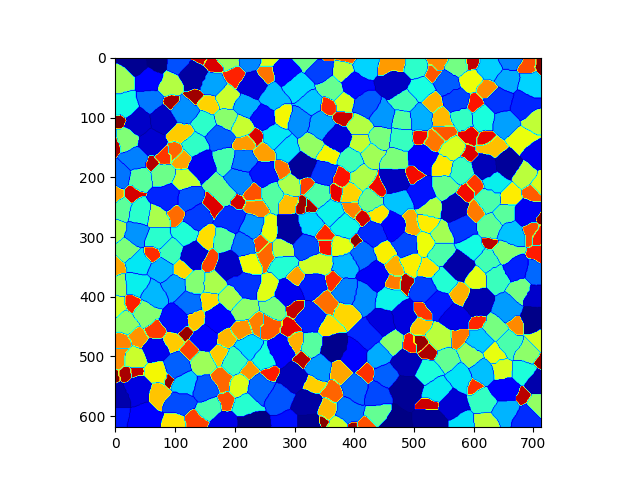

In [256]:
from skimage.segmentation import watershed

max_map = np.zeros_like(dist_map)
local_max_labels = np.arange(1,len(coords_max)+1)
max_map[tuple(coords_max.T)] = local_max_labels
wat_map = watershed(-dist_map, markers=max_map, compactness=0, watershed_line=True)

fig, ax = plt.subplots()
ax.imshow(wat_map, cmap='jet')
# ax.imshow(dist_map, cmap='gray', alpha=0.5)

plt.show()

On n'a alors pas encore tout à fait gagné, car on n'a dans cette image que les "zones d'influence" de chacune des particules. Mais si on multiplie cette image par l'image seuillée des particules (avec un seuil différent du premier seuil, ou non), nous obtenons ceci : 

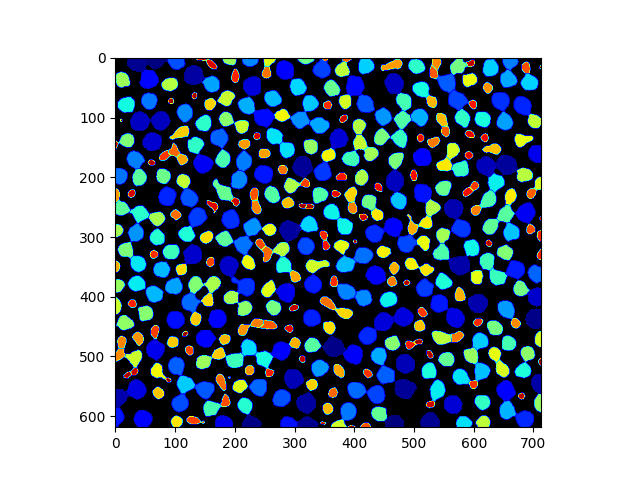

In [257]:
import matplotlib.cm as cm

prism = cm.get_cmap('jet')
prism.set_under('#000000')
my_threshold = 0.45

new_ths_img = filt_img > my_threshold
segmented_img = wat_map*ths_img

fig, ax = plt.subplots()
ax.imshow(segmented_img, cmap=prism, vmin=0.5)
plt.show()

On peut alors enfin décider de compter nos objets avec notre bonne vieille fonction `skimage.measure.regionprops_table()` et tracer les cercles correspondant à la taille (approximative) de nos particules. Vous pouvez en outre décider de ne tracer que celles qui sont suffisamment _circulaires_, ou de la bonne taille. Je vous montre ici un exemple un peu plus avancé qui permet de distinguer les particules des 'pas particules' en fonction de leur taille et excentricité, et où je trace en surimpression les formes (ellipses) correspondantes. 

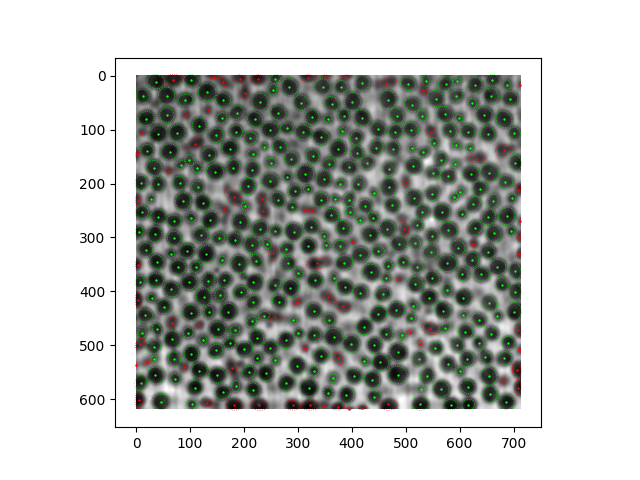

In [276]:
import numpy as np
import pandas as pd
from skimage.measure import regionprops_table

props = pd.DataFrame(regionprops_table(segmented_img, 
                        properties=['centroid', 'area', 'eccentricity', 'solidity', 'orientation', 
                                    'major_axis_length', 'minor_axis_length']))
props['rad'] = (props['area']/np.pi)**0.5
max_rad = np.max(props['rad'])

fig, ax = plt.subplots()
ax.imshow(filt_img, cmap='gray')

for index, row in props.iterrows():
    x, y, r, ecc = row['centroid-1'], row['centroid-0'], row['rad'], row['eccentricity']
    a, b, phi = 0.5*row['major_axis_length'], 0.5*row['minor_axis_length'], np.pi/2+row['orientation']
    
    theta = np.linspace(0, 2*np.pi, 60)
    x_ellipse = x + a*np.cos(theta)*np.cos(phi) + b*np.sin(theta)*np.sin(phi)
    y_ellipse = y - a*np.cos(theta)*np.sin(phi) + b*np.sin(theta)*np.cos(phi)

    if ecc > 0.75 or r < max_rad/3:
        mycolor = 'red'
    else:
        mycolor='lime'

    plt.plot(x, y, '+', markersize=1, linewidth=0.5, color=mycolor)
    plt.plot(x_ellipse, y_ellipse, ':', linewidth=0.5, color=mycolor)

plt.show()

Voilà ! La suite relève plus de votre interprétation personnelle de ce qui est ou n'est pas une particule. 

### Detection de particules 2 : Filtre de Canny et transformee de Hough

Reprenons notre image de la section précédente : 

![img](./resources/FredBlanc_Particles.png)

Si vous savez que vos particules sont circulaires, vous pouvez faire un peu mieux que la détection de contours par seuillage et segmentation 'simple'. On peut utiliser un type de _transformation_ d'image qui est particulièrement efficace pour détecter des cercles, la [transformée de Hough circulaire](https://en.wikipedia.org/wiki/Circle_Hough_Transform). Nous aurons cependant besoin non pas de particules, mais de _cercles_. Il va donc nous falloir récupérer les "bords" de l'image.

Pour cela, on va d'abord normaliser le contraste partout dans l'image avec un algorithme de CLAHE (cf. [section précédente](#detection-de-particules-1--filtre-gaussien-contraste-adaptatif-watershed)) puis utiliser un filtre appelé [filtre de _Canny_](https://fr.wikipedia.org/wiki/Filtre_de_Canny) [ici `skimage.feature.canny()`] qui va justement mettre en valeur les bords de l'image. Elle consiste _grosso modo_ à prendre la norme du _gradient_ de notre image filtrée passe-bas, par exemple avec un filtre gaussien -- dont on peut régler la taille avec le paramètre `sigma`. On obtient donc une image constituée uniquement des 'bords' détectés des particules.

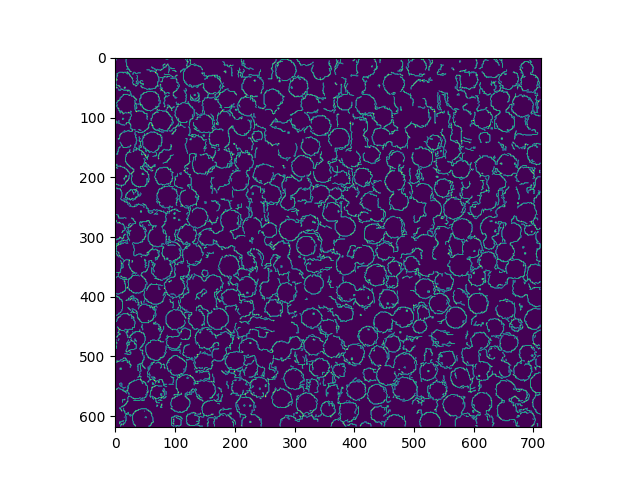

In [307]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import canny
from skimage.exposure import equalize_adapthist
from PIL import Image

my_img = np.array(Image.open('resources/FredBlanc_Particles.png').convert('L'))
filt_img = equalize_adapthist(my_img, kernel_size=64)
canny_img = canny(my_img, sigma=0.6)

fig, ax = plt.subplots()
ax.imshow(canny_img)
plt.show()

On va ensuite appliquer l'algorithme de la transformée de Hough circulaire : `skimage.transform.hough_circle()`. Celle-ci va, pour chaque pixel de l'image, tracer un cercle de rayon $r_0$ (`radius`) et va compter combien de pixels 'allumés' ce cercle intersecte. Si, d'aventure, le pixel de l'image considéré est au centre d'un contour de Canny (qui _devrait être un cercle et de surcroît de la même taille_), ce compte (l'_accumulateur_) va être très élevé. On pourra alors penser qu'on est bien en présence d'un cercle à cet endroit. On peut demander à l'algorithme de considérer des accumulateurs pour plusieurs tailles de particules, pour ne bien capturer des particules qui seraient plus petites ou plus grosses.

On peut ensuite aller chercher les maxima locaux correspondant à ces pics d'intensité, par exemple en utilisant `skimage.transform.hough_circle_peaks()`. Comme pour d'autres fonctions de `scikit-image`, on peut lui demander pas mal de conditions sur les pics, notamment en termes de distance.

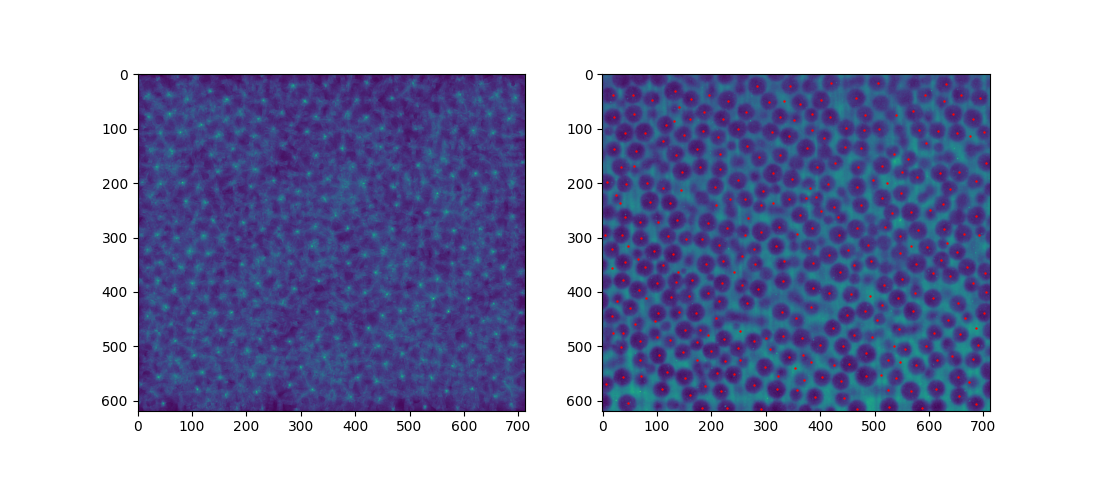

In [319]:
from skimage.transform import hough_circle, hough_circle_peaks

radii = np.arange(15,22)
accumulators = hough_circle(canny_img, radius=radii)
accums, x_circ, y_circ, r_circ = hough_circle_peaks(accumulators, radii=radii, min_xdistance=radii[0]-2, 
                                                    min_ydistance=radii[0]-2, threshold=0.30)

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(np.max(accumulators, axis=0))
axes[1].imshow(my_img)
axes[1].plot(x_circ, y_circ, 'r+', markersize=1)
fig.set_figwidth(11)
plt.show()

Je trouve cette méthode un peu plus hasardeuse lorsque la qualité de l'image n'est pas super bonne, ou qu'il existe des 'cavités' circulaires entre plusieurs particules qui peuvent également satisfaire par accident le critère de détection. 